# Description
from: https://archive.ics.uci.edu/ml/datasets/car+evaluation

1. Title: Car Evaluation Database

2. Sources:

    (a) Creator: Marko Bohanec

    (b) Donors: Marko Bohanec (marko.bohanec@ijs.si)
    Blaz Zupan (blaz.zupan@ijs.si)

    (c) Date: June, 1997

3. Past Usage:

    The hierarchical decision model, from which this dataset is
    derived, was first presented in

    M. Bohanec and V. Rajkovic: Knowledge acquisition and explanation for
    multi-attribute decision making. In 8th Intl Workshop on Expert
    Systems and their Applications, Avignon, France. pages 59-78, 1988.

    Within machine-learning, this dataset was used for the evaluation
    of HINT (Hierarchy INduction Tool), which was proved to be able to
    completely reconstruct the original hierarchical model. This,
    together with a comparison with C4.5, is presented in

    B. Zupan, M. Bohanec, I. Bratko, J. Demsar: Machine learning by
    function decomposition. ICML-97, Nashville, TN. 1997 (to appear)

4. Relevant Information Paragraph:
    Car Evaluation Database was derived from a simple hierarchical
    decision model originally developed for the demonstration of DEX
    (M. Bohanec, V. Rajkovic: Expert system for decision
    making. Sistemica 1(1), pp. 145-157, 1990.). The model evaluates
    cars according to the following concept structure:

5. CAR car acceptability
    - PRICE overall price
        - buying buying price
        -  maint price of the maintenance
    - TECH technical characteristics
        - COMFORT comfort
            - doors number of doors
            - persons capacity in terms of persons to carry
            - lug_boot the size of luggage boot
        - safety estimated safety of the car

    Input attributes are printed in lowercase. Besides the target
    concept (CAR), the model includes three intermediate concepts:
    PRICE, TECH, COMFORT. Every concept is in the original model
    related to its lower level descendants by a set of examples (for
    these examples sets see http://www-ai.ijs.si/BlazZupan/car.html).

    The Car Evaluation Database contains examples with the structural
    information removed, i.e., directly relates CAR to the six input
    attributes: buying, maint, doors, persons, lug_boot, safety.

    Because of known underlying concept structure, this database may be
    particularly useful for testing constructive induction and
    structure discovery methods.

6. Number of Instances: 1728
    (instances completely cover the attribute space)
    Number of Attributes: 6

7. Attribute Values:

    buying v-high, high, med, low
    maint v-high, high, med, low
    doors 2, 3, 4, 5-more
    persons 2, 4, more
    lug_boot small, med, big
    safety low, med, high

8. Missing Attribute Values: none

9. Class Distribution (number of instances per class)

    class N N[%]

# Data Set

    1. price (the buying price of the car)
    2. maint (the maintenance cost)
    3. doors (number of doors)
    4. persons (the seating capacity)
    5. lug_capacity (the luggage capacity)
    6. safetey (how safe is the car)
    7. output (the condition of the car)

# Import Modules 

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from sklearn import linear_model,pipeline,model_selection,preprocessing,tree,svm,decomposition
from sklearn import multioutput
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(palette='Dark2')

# Load Data Set: Classification

In [3]:
# data file does not contain file headers by default 
cols = ['price','maint','doors','persons','lug_capacity','safety','output']
cars = pd.read_csv('car_evaluation.csv',names=cols,header=None)
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         1728 non-null   object
 1   maint         1728 non-null   object
 2   doors         1728 non-null   object
 3   persons       1728 non-null   object
 4   lug_capacity  1728 non-null   object
 5   safety        1728 non-null   object
 6   output        1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [4]:
cars.head(5)

,price,maint,doors,persons,lug_capacity,safety,output
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [5]:
[cars[col].unique().tolist() for col in cols]

[['vhigh', 'high', 'med', 'low'],
 ['vhigh', 'high', 'med', 'low'],
 ['2', '3', '4', '5more'],
 ['2', '4', 'more'],
 ['small', 'med', 'big'],
 ['low', 'med', 'high'],
 ['unacc', 'acc', 'vgood', 'good']]

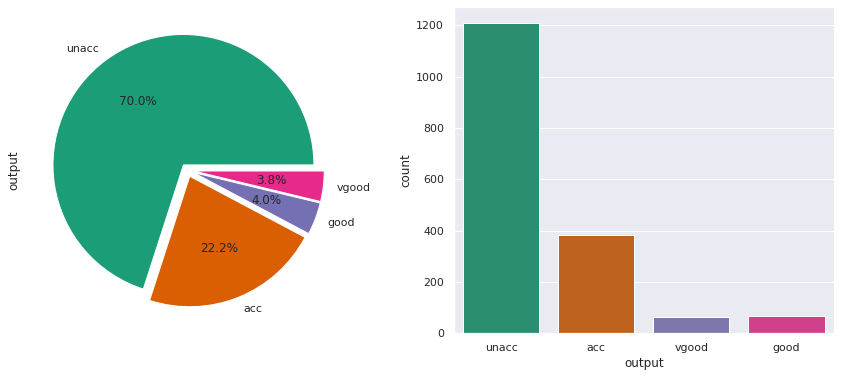

In [6]:
# plt.pie(cars['output'].value_counts(),autopct="%0.1f%%",explode=4*[0.05])
fig,ax = plt.subplots(1,2,figsize=(15,6))
cars['output'].value_counts().plot(kind='pie',autopct="%0.1f%%",explode=4*[0.05],ax=ax[0])
sns.countplot(data=cars,x='output',ax=ax[1])
plt.show()

# Convert columns with strings to dummy columns with binary values

    1. create list of objects types in dataframe cars without output
    2. copy cars in X and y where X is the features and y is the output
    3. Drop output column from X and y. (added later to y)
    4. loop through objects, create dummy dataframes and concatenate them to X. Then drop that object from X.
    5. Create dummy dataframe for output and concatenate dummy dataframe for output to y. Then drop all other objects from y. 
    6. convert X and y to numpy arrays
    7. Split data into train and test set. Probably don't need to do this because gridsearchcv will split them but I need it for the tensorflow analysis so I will use them here anyway. 

In [7]:
objects = [col for col in cars.keys() if cars[col].dtype == 'O' and col != 'output']

X = cars.copy(deep=True).drop(columns=['output'])
y = cars.copy(deep=True).drop(columns=['output'])

for o in objects:
    tmp = pd.get_dummies(cars[o],prefix=o)
    X = pd.concat([X,tmp],axis=1).drop(columns=[o])

tmp = pd.get_dummies(cars['output'],prefix='output')
y = pd.concat([y,tmp],axis=1).drop(columns=objects)    

# each column in X and y should be object type with column label + value of 
# 0 or 1 (false, true) to determine if that training example corresponds to 
# that given label
print(X.keys())
print(y.keys())

X = X.values
y = y.values

Xtrain,Xtest,ytrain,ytest = model_selection.train_test_split(X,y,test_size=0.2,random_state=42)

Index(['price_high', 'price_low', 'price_med', 'price_vhigh', 'maint_high',
       'maint_low', 'maint_med', 'maint_vhigh', 'doors_2', 'doors_3',
       'doors_4', 'doors_5more', 'persons_2', 'persons_4', 'persons_more',
       'lug_capacity_big', 'lug_capacity_med', 'lug_capacity_small',
       'safety_high', 'safety_low', 'safety_med'],
      dtype='object')
Index(['output_acc', 'output_good', 'output_unacc', 'output_vgood'], dtype='object')


# sklearn: Classification

    1. 
        - Use support vector machine with cross validation to choose the kernel type (linear,poly,rbf,sigmoid) and parameters of the kernel
        - Use pipeline to do feature scaling before traning model 
    2. 
        - Use pipeline to do feature scaling, principle component analysis, followed by decision tree classification 
        - Pass pipeline to cross validation to choose parameters of decision tree and the dimension of the PCA 
    
    3. 
        - Build pipeline of feature scaling and decision tree
        - Use cross validation to choose parameters of decision tree without PCA. The grid search is faster because we do not need to iterate over different dimensions of doing PCA and the error on the test set did slightly better 

In [8]:
parameters = {'clf__estimator__kernel':['linear','poly','rbf','sigmoid'],
              'clf__estimator__degree':range(1,4),
              'clf__estimator__gamma':[1,2,3,'auto','scale']}
pipe = pipeline.Pipeline([
                          ('std',preprocessing.StandardScaler()),
                          ('clf',multioutput.MultiOutputClassifier(estimator=svm.SVC()))
])
model = model_selection.GridSearchCV(pipe,
                                        parameters,
                                        refit=True,
                                        cv=model_selection.KFold(n_splits=5,shuffle=True),
                                        n_jobs=-1) 

model.fit(Xtrain,ytrain)
print('train score = ',model.score(Xtrain,ytrain))
print('test score = ',model.score(Xtest,ytest))
print('full score = ',model.score(X,y))
print(model.best_params_)
print(model.best_score_)

train score =  0.9985528219971056
test score =  0.953757225433526
full score =  0.9895833333333334
{'clf__estimator__degree': 2, 'clf__estimator__gamma': 1, 'clf__estimator__kernel': 'poly'}
0.9587558206456339


In [9]:
m,n = Xtrain.shape
print('training examples x features = ',(m,n))
parameters = {'decisiontreeclassifier__max_depth':range(1,20),
               'pca__n_components':range(1,n)} # range goes up to n - 1. I'm excluding the full features
pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),
                              decomposition.PCA(),
                              tree.DecisionTreeClassifier())
model = model_selection.GridSearchCV(pipe,
                                     parameters,
                                     refit=True,
                                     n_jobs=-1)
model.fit(Xtrain,ytrain)
print('train score = ',model.score(Xtrain,ytrain))
print('test score = ',model.score(Xtest,ytest))
print('full score = ',model.score(X,y))
print('best params = ',model.best_params_)

training examples x features =  (1382, 21)
train score =  1.0
test score =  0.846820809248555
full score =  0.9693287037037037
best params =  {'decisiontreeclassifier__max_depth': 14, 'pca__n_components': 17}


In [10]:
parameters = {'decisiontreeclassifier__max_depth':range(1,20)} 
pipe = pipeline.make_pipeline(preprocessing.StandardScaler(),
                               tree.DecisionTreeClassifier())
model = model_selection.GridSearchCV(pipe,
                                     parameters,
                                     refit=True,
                                     return_train_score=True,
                                     n_jobs=-1)
model.fit(Xtrain,ytrain)
print('train score = ',model.score(Xtrain,ytrain))
print('test score = ',model.score(Xtest,ytest))
print('full score = ',model.score(X,y))
print('best params = ',model.best_params_)

train score =  1.0
test score =  0.9653179190751445
full score =  0.9930555555555556
best params =  {'decisiontreeclassifier__max_depth': 17}


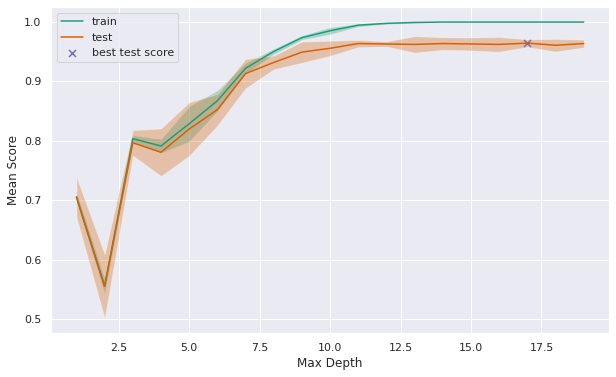

In [11]:
results = model.cv_results_
labels = ['train','test']
std = [results["std_%s_score"%split] for split in labels]
mean = [results["mean_%s_score"%split] for split in labels]

x = np.array(results["param_decisiontreeclassifier__max_depth"].data,dtype=float)
idx = model.best_index_
fig,ax = plt.subplots(figsize=(10,6))
for (m,s,l) in zip(mean,std,labels):
    ax.plot(x,m,label=l)
    ax.fill_between(x,m-s,m+s,alpha=0.3)
ax.scatter(x[idx],m[idx],s=50,marker="x",label="best test score")
ax.set(xlabel='Max Depth',ylabel='Mean Score')
plt.legend()
plt.show()

# TensorFlow: Classification

In [12]:
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import History

In [13]:
layers = [Input(shape=(Xtrain.shape[1],))] # list to store input layer, hidden layers, and output layer
nodes = [15,10] # number of nodes in the hidden 
# loop through nodes using the previous layer to set the current layer
for i in range(len(nodes)):
    lprev = layers[i]
    node = nodes[i]
    layers.append(Dense(node,activation='relu')(lprev))
# add the output layer
layers.append(Dense(y.shape[1],activation='softmax')(layers[-1]))
model = Model(inputs=layers[0],outputs=layers[-1])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 21)]              0         
_________________________________________________________________
dense (Dense)                (None, 15)                330       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 44        
Total params: 534
Trainable params: 534
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(Xtrain,ytrain,
                    batch_size=8,
                    epochs=50,
                    verbose=0,
                    validation_split=0.2,
                    callbacks=History())

In [15]:
score = model.evaluate(Xtrain,ytrain,verbose=1)
print("\nTrain Score",score[0])
print("Train Accuracy:",score[1])
print("")
score = model.evaluate(Xtest,ytest,verbose=1)
print("\nTest Score",score[0])
print("Test Accuracy:",score[1])

44/44 [==============================] - 0s 949us/step - loss: 0.0097 - acc: 0.9993

Train Score 0.009698576293885708
Train Accuracy: 0.9992763996124268

11/11 [==============================] - 0s 1ms/step - loss: 0.0511 - acc: 0.9855

Test Score 0.051058921962976456
Test Accuracy: 0.9855491518974304


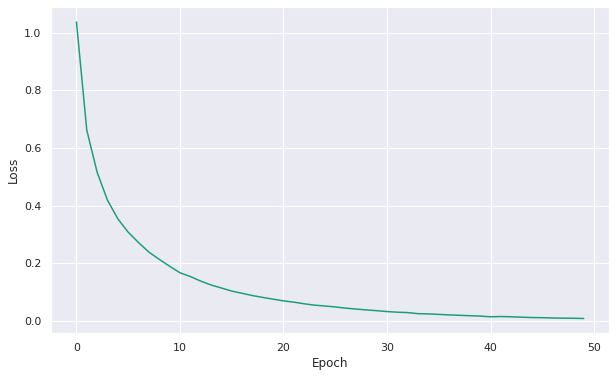

In [16]:
hist = pd.DataFrame(history.history)
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(hist['loss'])
ax.set(xlabel='Epoch',ylabel='Loss')
plt.show()

# sklearn: Regression 

Data taken from https://stackabuse.com/tensorflow-2-0-solving-classification-and-regression-problems/

There are 4 columns

    1. Petrol tax
    2. Average income
    3. Paved Highways 
    4. Population Driver Licence (%)
    5. Petrol Consumption

The first 4 columns are the features of the training examples which will be used to predict the continuous output of the petrol consumption

In [17]:
petrol_cons = pd.read_csv(r'petrol_consumption.csv')
petrol_cons.head(5)

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,9.0,3571,1976,0.525,541
1,9.0,4092,1250,0.572,524
2,9.0,3865,1586,0.580,561
3,7.5,4870,2351,0.529,414
4,8.0,4399,431,0.544,410


In [18]:
# load training examples into features X and output y
X = petrol_cons.drop(columns=['Petrol_Consumption']).values
y = petrol_cons['Petrol_Consumption'].values
print(X.shape,y.shape)

(48, 4) (48,)


In [19]:
# split data set 
Xtrain,Xtest,ytrain,ytest = model_selection.train_test_split(X,y,test_size=0.2,random_state=42)

In [20]:
parameters = {'pf__degree':range(1,4),
              'lm__alpha':np.logspace(-4,1,4,endpoint=True)} 
pipe = pipeline.Pipeline([
                          ('std',preprocessing.StandardScaler()),
                          ('pf',preprocessing.PolynomialFeatures()),
                          ('lm',linear_model.Ridge())
])
model = model_selection.GridSearchCV(pipe,
                                     parameters,
                                     refit=True,
                                     scoring='neg_root_mean_squared_error',
                                     return_train_score=True,
                                     n_jobs=-1)
model.fit(Xtrain,ytrain)
print('Negative RMSE of train set = ',model.score(Xtrain,ytrain))
print('Negative RMSE of test set = ',model.score(Xtest,ytest))
print('Negative RMSE of full set = ',model.score(X,y))
print('best params = ',model.best_params_)
print('best RMSE = ',model.best_score_)

Negative RMSE of train set =  -55.28088656427234
Negative RMSE of test set =  -61.00820707053167
Negative RMSE of full set =  -56.52195687559222
best params =  {'lm__alpha': 10.0, 'pf__degree': 2}
best RMSE =  -64.35095596493976


In [21]:
parameters = {'pf__degree':range(1,5),
              'model__alpha':np.logspace(-4,1,4,endpoint=True),
              'model__loss':['squared_loss',
                             'huber',
                             'epsilon_insensitive',
                             'squared_epsilon_insensitive']
}

pipe = pipeline.Pipeline([
                          ('std',preprocessing.StandardScaler()),
                          ('pf',preprocessing.PolynomialFeatures()),
                          ('model',linear_model.SGDRegressor())
])
model = model_selection.GridSearchCV(pipe,
                                     parameters,
                                     refit=True,
                                     scoring='neg_root_mean_squared_error',
                                     return_train_score=True,
                                     n_jobs=-1)
model.fit(Xtrain,ytrain)
print('train score = ',model.score(Xtrain,ytrain))
print('test score = ',model.score(Xtest,ytest))
print('full score = ',model.score(X,y))
print('best params = ',model.best_params_)
print('best score = ',model.best_score_)

train score =  -65.3025320119238
test score =  -61.32273570503815
full score =  -64.49366332825139
best params =  {'model__alpha': 0.21544346900318845, 'model__loss': 'squared_epsilon_insensitive', 'pf__degree': 1}
best score =  -68.0140141961289


# TensorFlow Regression

In [22]:
std = preprocessing.StandardScaler()
std.fit(Xtrain)
Xtrain,Xtest = [std.transform(x) for x in [Xtrain,Xtest]]

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               500       
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 26        
Total params: 6,851
Trainable params: 6,851
Non-trainable params: 0
_________________________________________________________________
2/2 [==============================] - 0s 9ms/step - loss: 3662.9980 - mean_squared_error: 3662.9980

Test RMSE =  60.52270

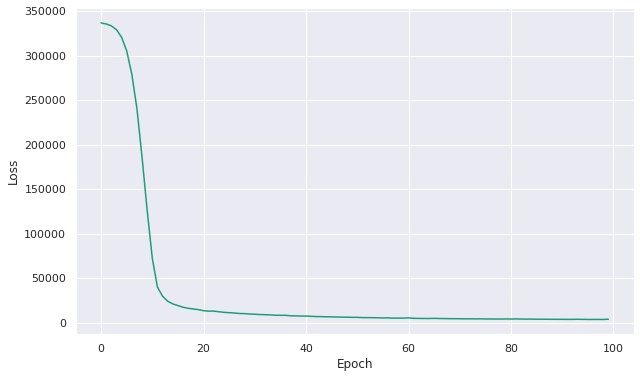

In [23]:
input_layer = Input(shape=(X.shape[1],))
dense_layer_1 = Dense(100, activation='relu')(input_layer)
dense_layer_2 = Dense(50, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(25, activation='relu')(dense_layer_2)
output = Dense(1)(dense_layer_3)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
model.summary()

history = model.fit(Xtrain,ytrain,
                    batch_size=2,
                    epochs=100,
                    verbose=0,
                    validation_split=0.2,
                    callbacks=History())
score = model.evaluate(Xtrain,ytrain,verbose=1)
print("\nTest RMSE = ",score[0]**0.5)
print("")
score = model.evaluate(Xtest,ytest,verbose=1)
print("\nTest RMSE = ",score[0]**0.5)

hist = pd.DataFrame(history.history)
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(hist['loss'])
ax.set(xlabel='Epoch',ylabel='Loss')
plt.show()

In [24]:
petrol_cons.head(2)

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,9.0,3571,1976,0.525,541
1,9.0,4092,1250,0.572,524


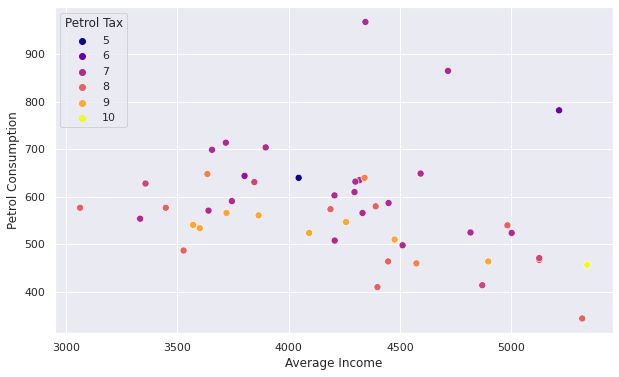

In [25]:
fig,ax = plt.subplots(figsize=(10,6))
sns.scatterplot(data=petrol_cons,
                x="Average_income",
                y="Petrol_Consumption",
                hue="Petrol_tax",
                s=50,
                palette="plasma")
ax.set(xlabel="Average Income",ylabel="Petrol Consumption")
plt.legend(title="Petrol Tax")
plt.show()